#### requiements
- pip install tensorflow_datasets 
- pip install protobuf==3.20

In [29]:
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    'cats_vs_dogs',
    # 0~10 구간 train, 10~20% 구간 val, 20~30%구간 test
    split=['train[:10%]', 'train[10%:20%]', 'train[20%:30%]'],
    as_supervised=True, # label 포함(지도학습)
)

tf.data.experimental.cardinality(train_ds), tf.data.experimental.cardinality(validation_ds), tf.data.experimental.cardinality(test_ds)

(<tf.Tensor: shape=(), dtype=int64, numpy=2326>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2326>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2327>)

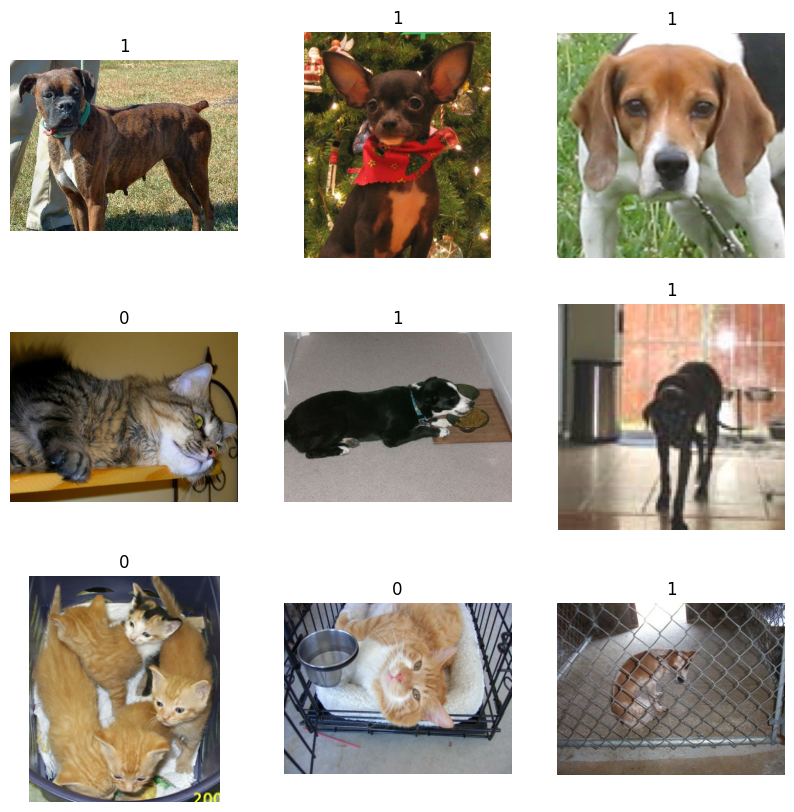

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

In [31]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [32]:
batch_size = 1
train_ds = train_ds.take(600).batch(batch_size)
validation_ds = validation_ds.take(200).batch(batch_size)
test_ds = test_ds.take(200).batch(batch_size)

In [33]:
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, Dense
from tensorflow.keras import Sequential, Input

data_augmentation = Sequential(
    [RandomFlip("horizontal"), RandomRotation(0.1),]
)

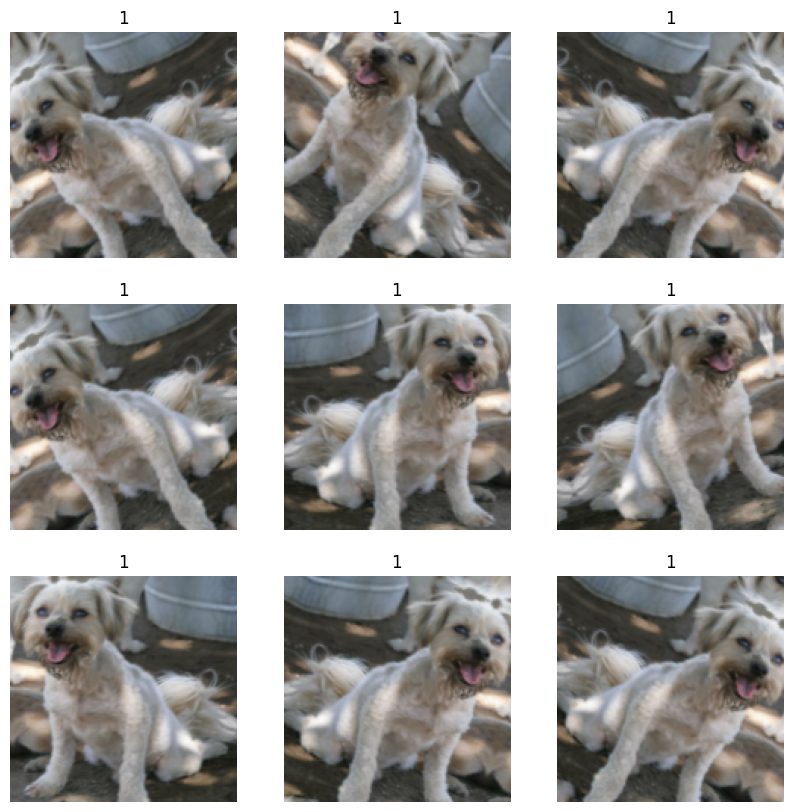

In [25]:
import numpy as np
tf.get_logger().setLevel('ERROR')
for images, labels in train_ds.skip(100).take(1):
    plt.figure(figsize=(10,10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype('int32'))
        plt.title(int(labels[0]))
        plt.axis('off')

In [35]:
base_model = tf.keras.applications.vgg19.VGG19(

    weights="imagenet",  # Load weights pre-trained on ImageNet.

    input_shape=(150, 150, 3),

    include_top=False, # output layer 제거

)

base_model.trainable = False #레이어 동결

inputs = keras.Input(shape=(150, 150, 3))

x = data_augmentation(inputs)  

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

x = scale_layer(x)

x = base_model(x, training=False) # 사전훈련 모델

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(1)(x)

model1 = keras.Model(inputs, outputs)

model1.compile(

    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate

    loss=keras.losses.BinaryCrossentropy(from_logits=True),

    metrics=[keras.metrics.BinaryAccuracy()],

)

model1.summary()

# Total params: 20,024,897

# Trainable params: 513

# Non-trainable params: 20,024,384 (기본모델의 레이어가 동결된 상태)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, None, 3)      0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [36]:
epochs =2 
model1.fit(train_ds, epochs = epochs, validation_data=validation_ds)

Epoch 1/2
600/600 [==============================] - 47s 76ms/step - loss: 0.9892 - binary_accuracy: 0.4700 - val_loss: 0.8791 - val_binary_accuracy: 0.4900
Epoch 2/2
600/600 [==============================] - 47s 78ms/step - loss: 0.9057 - binary_accuracy: 0.4800 - val_loss: 0.8125 - val_binary_accuracy: 0.4950


In [37]:
# fine tuning
base_model.trainable = True # 레이어 동결 해제
model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, None, 3)      0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                           

In [39]:
model2.compile(
    optimizer = keras.optimizers.Adam(1e-5), # Low learning rate
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)

In [40]:
epochs = 2
model2.fit(train_ds, epochs = epochs, validation_data = validation_ds)

Epoch 1/2
600/600 [==============================] - 330s 546ms/step - loss: 0.4482 - binary_accuracy: 0.7900 - val_loss: 0.2406 - val_binary_accuracy: 0.9000
Epoch 2/2
600/600 [==============================] - 329s 548ms/step - loss: 0.2629 - binary_accuracy: 0.8717 - val_loss: 0.2005 - val_binary_accuracy: 0.9350
